# End-to-end Project: Medical No Show Rate Prediction

Dataset
* Patient medical appointment that contains medical appointment history and their no-show status for each appointment.
* Data Dictionary: see attached data_ref.csv

Questions
* Develop model(s) that predict patient’s probability of no-show and outline approach
* Based on findings to provide suitable recommendations would make to the operation unit efficiency

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 1. Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

# 2. Import Data 

In [3]:
df = pd.read_csv('Medical_No_Shows.csv')

# 3. Exploratroy Data Analysis

## 3.1 Data Quality Control: info, shape, missing values, duplicates

In [4]:
df.shape

(110527, 14)

In [5]:
df.head(10)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,LocationID,MedicaidIND,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,No-show
0,#29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,40,0,1,0,0,0,0,No
1,#558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,40,0,0,0,0,0,0,No
2,#4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,47,0,0,0,0,0,0,No
3,#867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,55,0,0,0,0,0,0,No
4,#8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,40,0,1,1,0,0,0,No
5,#95985133231274,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,59,0,1,0,0,0,0,No
6,#733688164476661,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,26,0,0,0,0,0,0,Yes
7,#3449833394123,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,26,0,0,0,0,0,0,Yes
8,#56394729949972,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,2,0,0,0,0,0,0,No
9,#78124564369297,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,13,0,0,0,0,0,0,No


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientID       110527 non-null  object
 1   AppointmentID   110527 non-null  int64 
 2   Gender          110527 non-null  object
 3   ScheduledDay    110527 non-null  object
 4   AppointmentDay  110527 non-null  object
 5   Age             110527 non-null  int64 
 6   LocationID      110527 non-null  int64 
 7   MedicaidIND     110527 non-null  int64 
 8   Hypertension    110527 non-null  int64 
 9   Diabetes        110527 non-null  int64 
 10  Alcoholism      110527 non-null  int64 
 11  Disability      110527 non-null  int64 
 12  SMS_received    110527 non-null  int64 
 13  No-show         110527 non-null  object
dtypes: int64(9), object(5)
memory usage: 11.8+ MB


In [7]:
for col in df:
    print('{:14s}: {:6d} unique values'.format(col, len(df[col].unique()))) # https://docs.python.org/2/library/string.html#format-specification-mini-language

PatientID     :  62299 unique values
AppointmentID : 110527 unique values
Gender        :      2 unique values
ScheduledDay  : 103549 unique values
AppointmentDay:     27 unique values
Age           :    104 unique values
LocationID    :     81 unique values
MedicaidIND   :      2 unique values
Hypertension  :      2 unique values
Diabetes      :      2 unique values
Alcoholism    :      2 unique values
Disability    :      5 unique values
SMS_received  :      2 unique values
No-show       :      2 unique values


In [8]:
# get missing value percentages per feature 
print(df.isnull().sum()/len(df)*100)

PatientID         0.0
AppointmentID     0.0
Gender            0.0
ScheduledDay      0.0
AppointmentDay    0.0
Age               0.0
LocationID        0.0
MedicaidIND       0.0
Hypertension      0.0
Diabetes          0.0
Alcoholism        0.0
Disability        0.0
SMS_received      0.0
No-show           0.0
dtype: float64


In [9]:
# check duplicates
len(df.drop_duplicates()) < len(df)

False

## 3.2 Feature Enginnering

In [10]:
# create target
df['NoShow'] = df['No-show'].map(lambda x: 1 if x == 'Yes' else 0)

In [11]:
# creat feature: LeadTime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['LeadTime'] = df['AppointmentDay'] - df['ScheduledDay']
df['LeadTime'] = df['LeadTime'].dt.days + 1 # appointments that happened in the same day take value of -1

df = df[df['LeadTime'] >= 0]

### Create features about patient history

In [12]:
# create feaure: totol_noshows_before
totol_noshows_before = df.groupby('PatientID')['NoShow'].cumsum().to_frame().rename(columns={'NoShow':'totol_noshows_before'})
df = df.merge(totol_noshows_before, left_index=True, right_index=True, how="outer")  

In [13]:
# create feature: totol_appointments_before
df['Appointment'] = 1
totol_appointments_before = df.groupby('PatientID')['Appointment'].cumsum().to_frame().rename(columns={'Appointment':'totol_appointments_before'})
df = df.merge(totol_appointments_before , left_index=True, right_index=True, how="outer")
df['totol_appointments_before'] = df['totol_appointments_before'] - 1

In [14]:
df[df['PatientID'] == '#1421986987763']

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,LocationID,MedicaidIND,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,No-show,NoShow,LeadTime,totol_noshows_before,Appointment,totol_appointments_before
53206,#1421986987763,5683659,M,2016-05-11 07:44:50+00:00,2016-05-11 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,1,1,0
53218,#1421986987763,5660212,M,2016-05-04 15:50:42+00:00,2016-05-04 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,2,1,1
53323,#1421986987763,5660224,M,2016-05-04 15:51:21+00:00,2016-05-04 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,3,1,2
53381,#1421986987763,5740918,M,2016-05-25 16:34:32+00:00,2016-05-25 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,4,1,3
53387,#1421986987763,5683709,M,2016-05-11 07:47:24+00:00,2016-05-11 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,5,1,4
53400,#1421986987763,5660301,M,2016-05-04 16:05:24+00:00,2016-05-04 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,6,1,5
53418,#1421986987763,5660316,M,2016-05-04 16:07:01+00:00,2016-05-04 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,7,1,6
70906,#1421986987763,5740886,M,2016-05-25 16:28:35+00:00,2016-05-25 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,8,1,7
70914,#1421986987763,5683830,M,2016-05-11 07:55:08+00:00,2016-05-11 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,9,1,8
70935,#1421986987763,5660323,M,2016-05-04 16:08:03+00:00,2016-05-04 00:00:00+00:00,9,62,0,0,0,0,1,0,Yes,1,0,10,1,9


In [15]:
features = list(df.columns)
target = 'NoShow'
features.remove(target)
features.remove('No-show')
features.remove('PatientID')
features.remove('AppointmentID')
features.remove('ScheduledDay')
features.remove('AppointmentDay')
features.remove('Appointment')
features.remove('LocationID')

In [16]:
numerical_features = ['Age', 'LeadTime', 'totol_noshows_before', 'totol_appointments_before']

categorical_features = ['Gender',
                        'MedicaidIND', 'Hypertension', 
                        'Diabetes', 'Alcoholism', 
                        'Disability', 'SMS_received']

In [17]:
df[categorical_features] = df[categorical_features].astype(str)

In [18]:
X = df[features]
y = df[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, stratify=y)

In [19]:
X

,Gender,Age,MedicaidIND,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,LeadTime,totol_noshows_before,totol_appointments_before
0,F,62,0,1,0,0,0,0,0,0,0
1,M,56,0,0,0,0,0,0,0,0,0
2,F,62,0,0,0,0,0,0,0,0,0
3,F,8,0,0,0,0,0,0,0,0,0
4,F,56,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
110522,F,56,0,0,0,0,0,1,35,1,1
110523,F,51,0,0,0,0,0,1,35,1,3
110524,F,21,0,0,0,0,0,1,41,0,0
110525,F,38,0,0,0,0,0,1,41,0,1


In [20]:
y

0         0
1         0
2         0
3         0
4         0
         ..
110522    0
110523    0
110524    0
110525    0
110526    0
Name: NoShow, Length: 110522, dtype: int64

In [21]:
X_train

,Gender,Age,MedicaidIND,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,LeadTime,totol_noshows_before,totol_appointments_before
71721,F,35,0,0,0,0,0,0,0,0,3
91358,F,12,0,0,0,0,0,0,0,0,1
64454,F,56,0,1,1,0,0,0,6,1,0
82016,F,27,0,1,0,0,0,0,0,0,1
9564,F,33,1,0,0,0,0,0,35,0,1
...,...,...,...,...,...,...,...,...,...,...,...
80128,M,64,0,0,0,0,0,0,2,0,0
12148,M,5,0,0,0,0,0,0,6,0,0
78353,F,39,0,0,0,0,0,0,2,1,0
86731,M,6,0,0,0,0,0,1,15,0,0


In [22]:
y_train

71721    0
91358    0
64454    1
82016    0
9564     0
        ..
80128    0
12148    0
78353    1
86731    0
27509    0
Name: NoShow, Length: 88417, dtype: int64

In [23]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [24]:
train

,Gender,Age,MedicaidIND,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,LeadTime,totol_noshows_before,totol_appointments_before,NoShow
71721,F,35,0,0,0,0,0,0,0,0,3,0
91358,F,12,0,0,0,0,0,0,0,0,1,0
64454,F,56,0,1,1,0,0,0,6,1,0,1
82016,F,27,0,1,0,0,0,0,0,0,1,0
9564,F,33,1,0,0,0,0,0,35,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
80128,M,64,0,0,0,0,0,0,2,0,0,0
12148,M,5,0,0,0,0,0,0,6,0,0,0
78353,F,39,0,0,0,0,0,0,2,1,0,1
86731,M,6,0,0,0,0,0,1,15,0,0,0


In [25]:
for cat in categorical_features:
    print(train[cat].value_counts())
    print('\n')

F    57480
M    30937
Name: Gender, dtype: int64


0    79734
1     8683
Name: MedicaidIND, dtype: int64


0    70996
1    17421
Name: Hypertension, dtype: int64


0    82094
1     6323
Name: Diabetes, dtype: int64


0    85742
1     2675
Name: Alcoholism, dtype: int64


0    86634
1     1620
2      153
3        8
4        2
Name: Disability, dtype: int64


0    60009
1    28408
Name: SMS_received, dtype: int64




## 3.3 NoShow vs. Feature

In [26]:
sns.set_theme()

In [27]:
sns.set(font_scale=1)

<Axes: xlabel='NoShow', ylabel='count'>

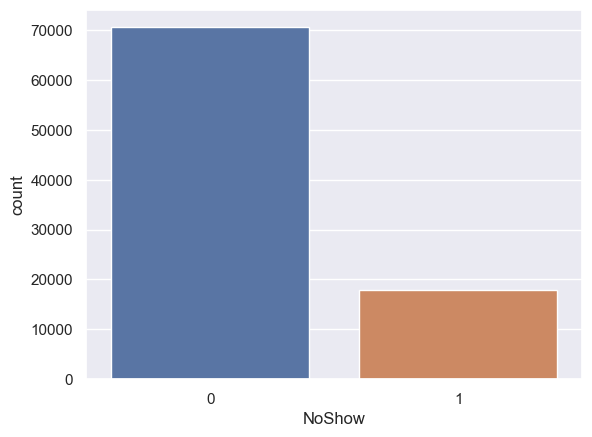

In [28]:
sns.countplot(x=target, data=train)

### Insights: imblanced data

**Count bin number**

In [29]:
len(train['Age'].unique())

104

In [37]:
train['Age'].min()

-1

In [38]:
train['Age'].max()

115

In [40]:
train['Age'].sort_values()

99832      -1
99790       0
102707      0
82701       0
29686       0
         ... 
90372     102
97666     115
68127     115
63912     115
63915     115
Name: Age, Length: 88417, dtype: int64

In [41]:
train = train[train['Age'] >= 0]

In [42]:
train['Age'].sort_values()

89143       0
101581      0
17533       0
48663       0
76611       0
         ... 
90372     102
97666     115
68127     115
63912     115
63915     115
Name: Age, Length: 88416, dtype: int64

In [30]:
1 + 3.322 * np.log(104)

16.42866656694764

In [31]:
len(train['LeadTime'].unique())

127

In [32]:
1 + 3.322 * np.log(127)

17.09238950121544

In [33]:
len(train['totol_noshows_before'].unique())

19

In [34]:
1 + 3.322 * np.log(19)

10.781426288790914

In [35]:
len(train['totol_appointments_before'].unique())

86

In [36]:
1 + 3.322 * np.log(86)

15.797341718154152

**Age vs NoShow**

<Axes: xlabel='Age', ylabel='Count'>

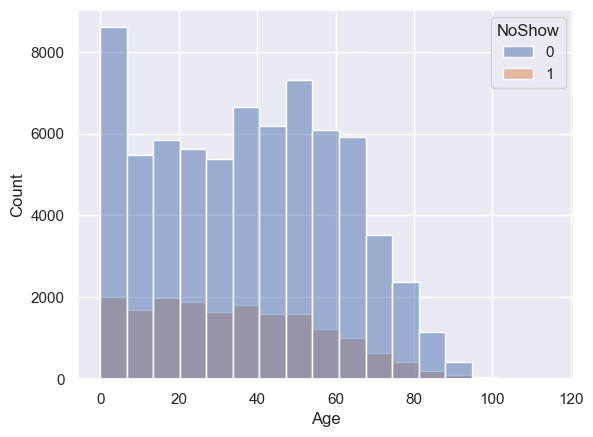

In [43]:
sns.histplot(data=train, x='Age', hue=target, bins=17)

<Axes: xlabel='Age', ylabel='Percent'>

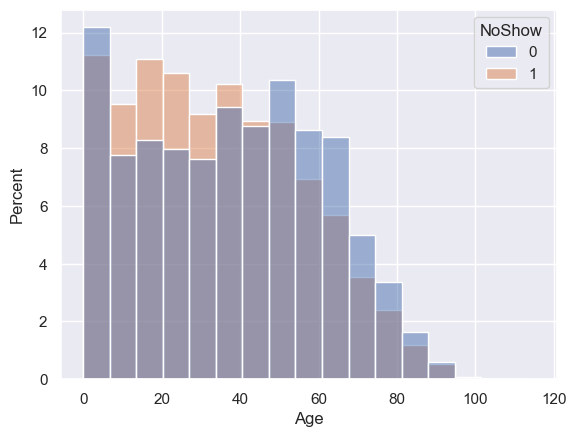

In [44]:
sns.histplot(data=train, x='Age', hue=target, stat='percent', common_norm=False, bins=17)

### Insights: NoShow group with lower average age

**LeadTime vs NoShow**

<Axes: xlabel='LeadTime', ylabel='Count'>

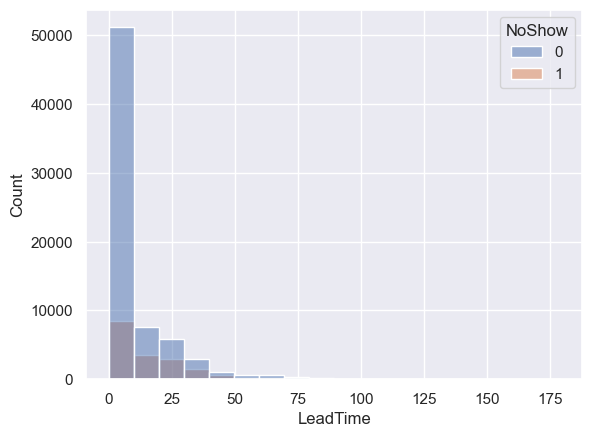

In [45]:
sns.histplot(data=train, x='LeadTime', hue=target, bins=18)

<Axes: xlabel='LeadTime', ylabel='Percent'>

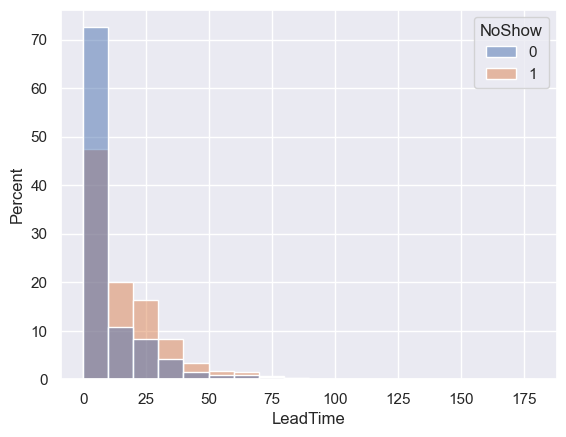

In [46]:
sns.histplot(data=train, x='LeadTime', hue=target, stat='percent', common_norm=False, bins=18)

### Insights: NoShow group with longer lead time

In [47]:
bins = [17, 18, 11, 16]
hue_order = [0, 1]
order = [0, 1]

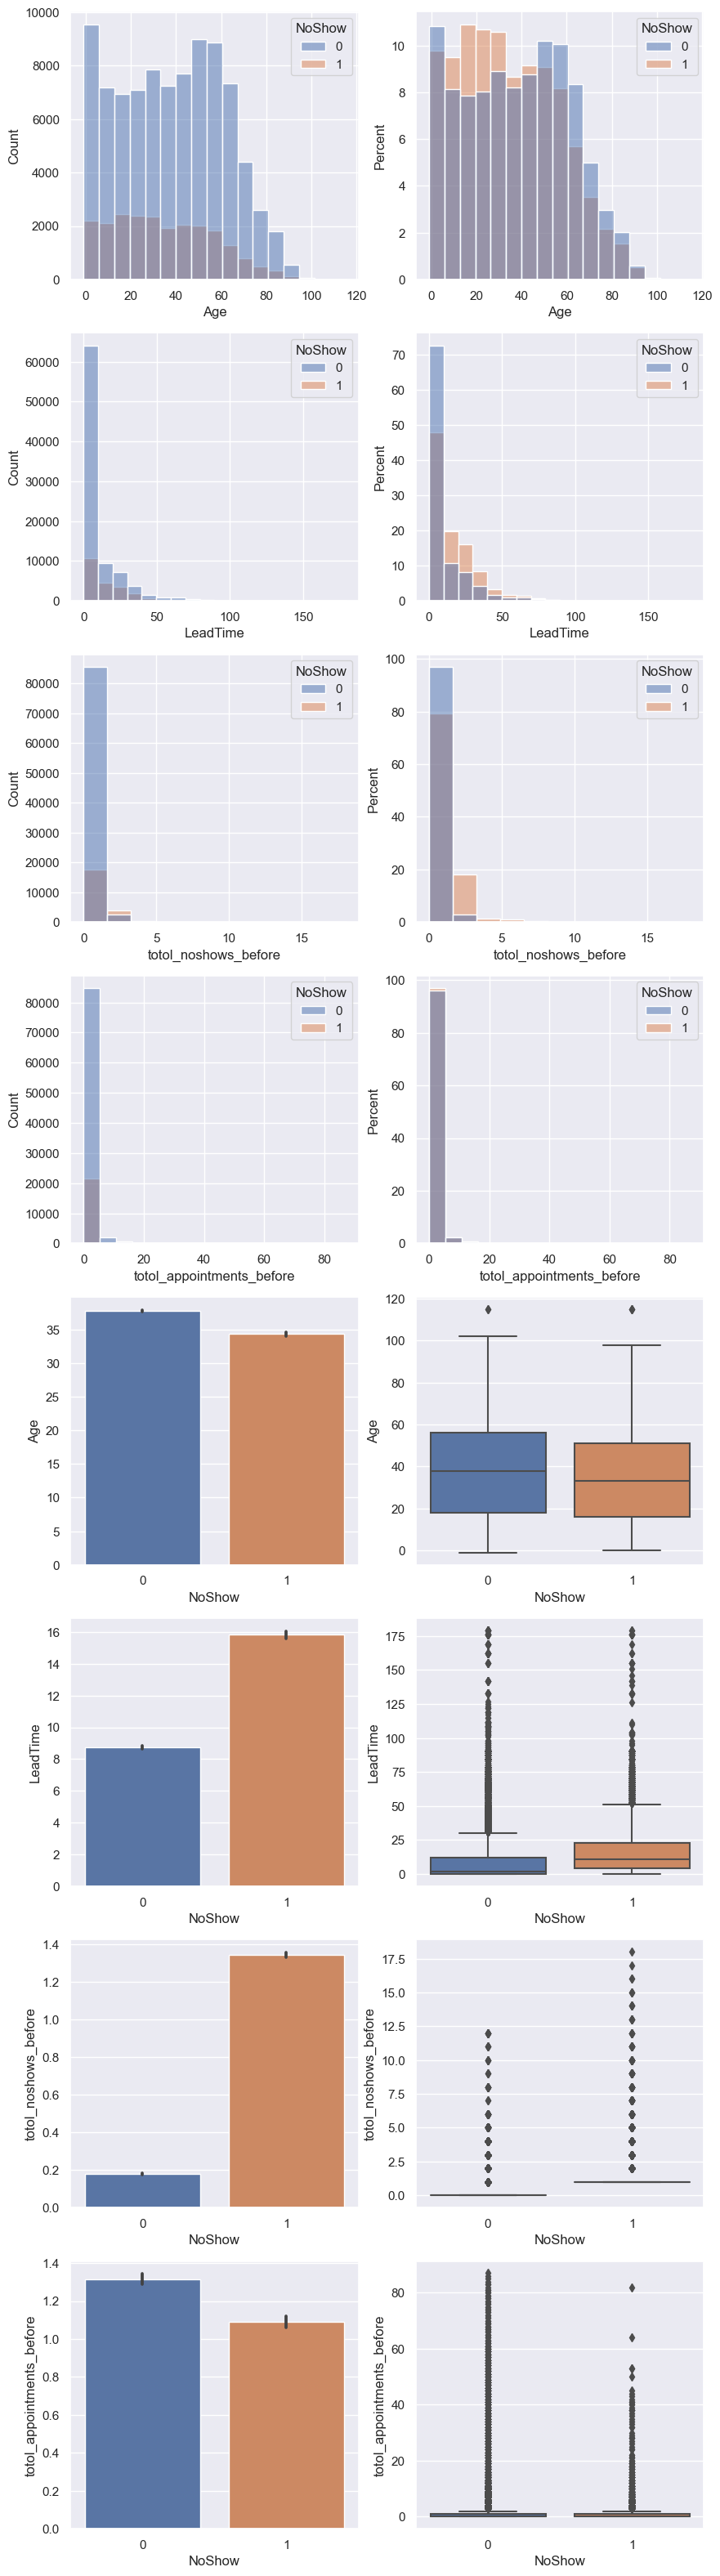

In [48]:
plt.figure(figsize=(10, 40))

for i, num in enumerate(numerical_features):
    plt.subplot(8, 2, i * 2 + 1)
    sns.histplot(data=df, x=num, hue=target, bins=bins[i])
    
    plt.subplot(8, 2, i * 2 + 2)
    sns.histplot(data=df, x=num, hue=target, stat='percent', common_norm=False, bins=bins[i])
    
    plt.subplot(8, 2, i * 2 + 9)
    sns.barplot(data=df, x=target, y=num, order=order)
    
    plt.subplot(8, 2, i * 2 + 10)
    sns.boxplot(data=df, x=target, y=num, order=order)

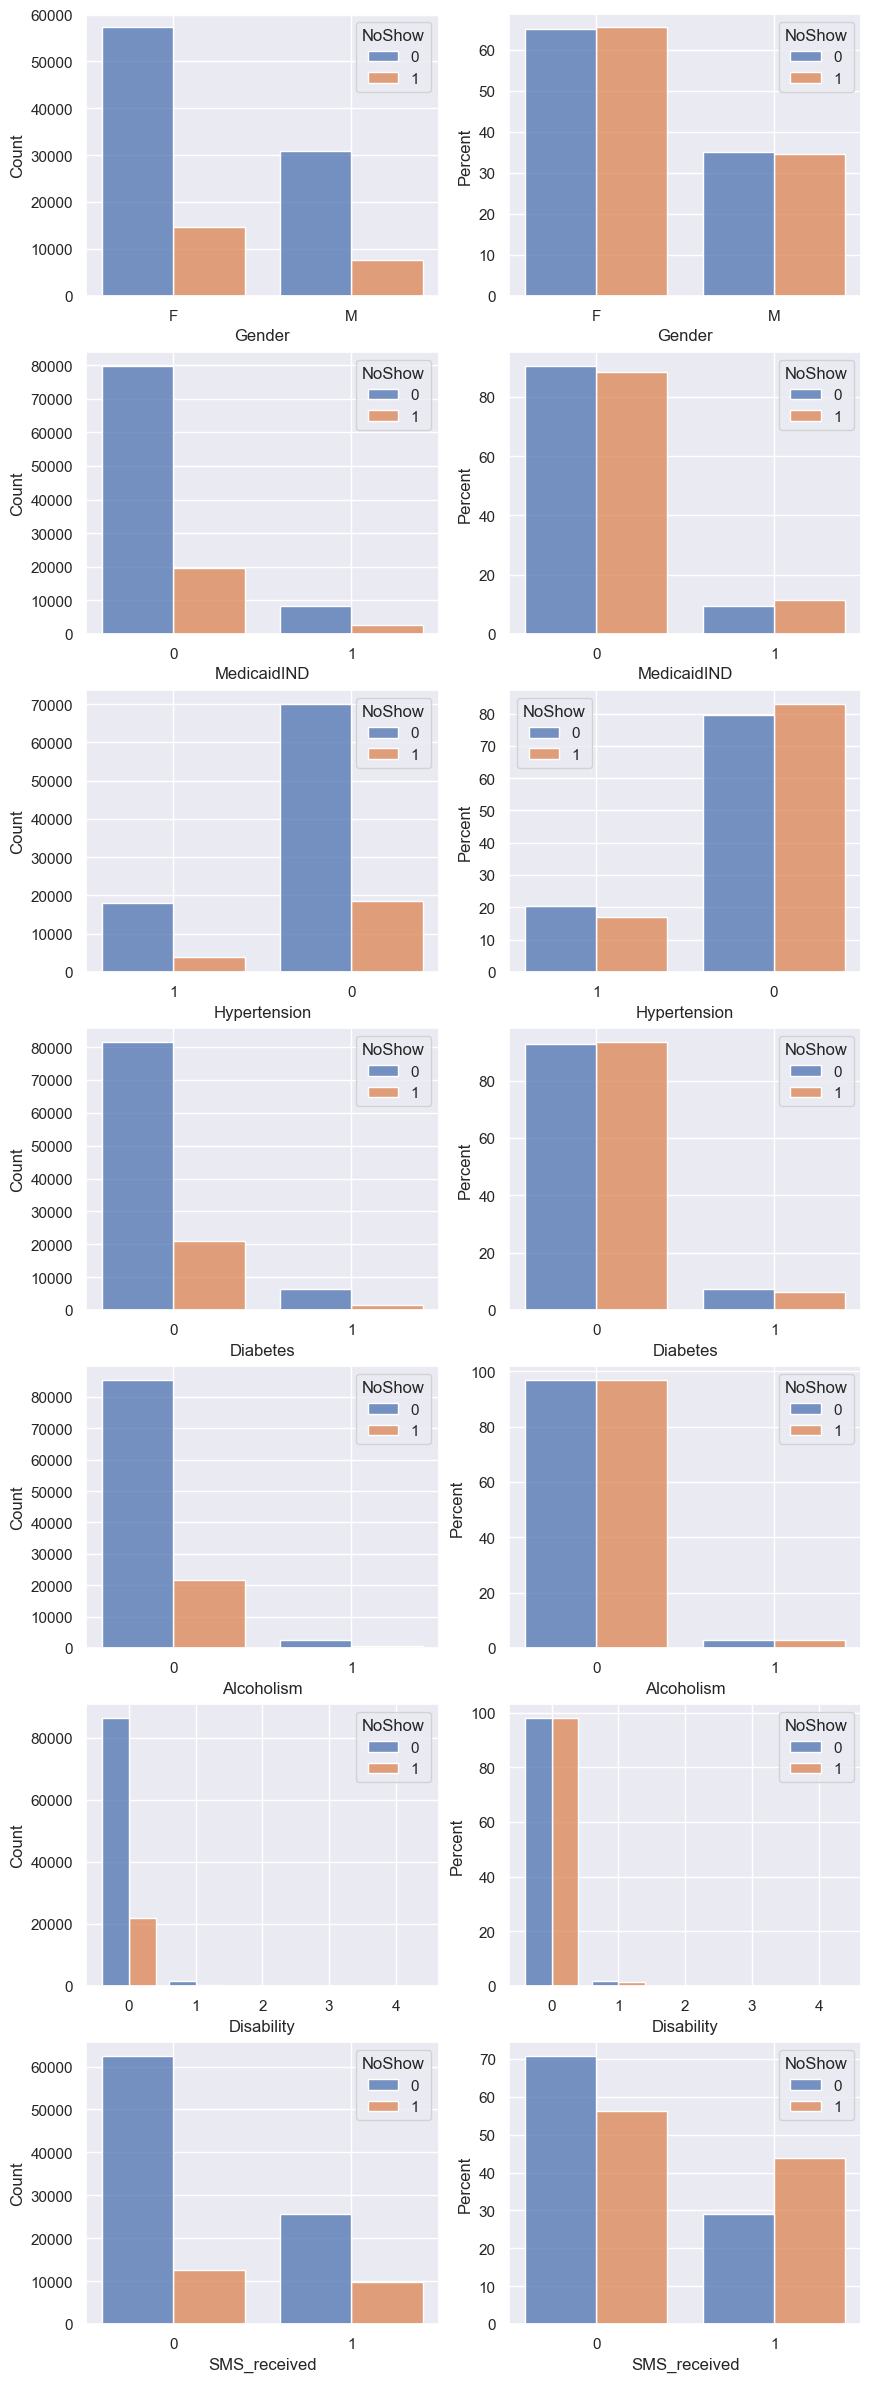

In [49]:
plt.figure(figsize=(10, 30))

for i, cat in enumerate(categorical_features):
    plt.subplot(7, 2, i * 2 + 1)
    sns.histplot(data=df, x=cat, hue=target, hue_order=hue_order, multiple='dodge', shrink=0.8)
    plt.subplot(7, 2, i * 2 + 2)
    sns.histplot(data=df, x=cat, hue=target, hue_order=hue_order, multiple='dodge', stat='percent', common_norm=False, shrink=0.8)

### Insights: NoShow group tend to have lower age, longer lead time, larger total number of No-shows before, smaller total number of appointments before.

### Insights: Medicaid, Hypertension, Diabetes, and SMS_received can have an impact on NoShow

## 3.4 Statistical tests

In [50]:
from scipy import stats

In [51]:
for num in numerical_features:
    d1 = np.array(train[train[target] == 0][num])
    d2 = np.array(train[train[target] == 1][num])
    s, p = stats.ttest_ind(d1, d2)
    print('{:25s} vs {}: statistics = {:.4f}, p = {:.4f}'.format(num, target, s, p))

Age                       vs NoShow: statistics = 18.3539, p = 0.0000
LeadTime                  vs NoShow: statistics = -55.9700, p = 0.0000
totol_noshows_before      vs NoShow: statistics = -213.7925, p = 0.0000
totol_appointments_before vs NoShow: statistics = 6.4792, p = 0.0000


### Insights: All numerical featrues are statistically significantly different btw the Show and NoShow group

In [ ]:
# !pip install bioinfokit

In [52]:
from bioinfokit.analys import stat, get_data
for cat in categorical_features:
    res = stat()
    contingency_table = pd.crosstab(y_train, X_train[cat])
    res.chisq(df=contingency_table)
    print('NoShow vs.', cat)
    print(res.summary)
    print()

NoShow vs. Gender

Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1       1.57939   0.208849
Log-likelihood     1       1.58149   0.208546


NoShow vs. MedicaidIND

Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            1       67.7816  1.82644e-16
Log-likelihood     1       65.4826  5.86305e-16


NoShow vs. Hypertension

Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            1       116.629  3.46086e-27
Log-likelihood     1       120.122  5.94756e-28


NoShow vs. Diabetes

Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            1       18.7231  1.51143e-05
Log-likelihood     1       19.1989  1.1778e-05


NoSh

### Insights: Gender, Alcoholism, and Disability are not statistically significantly related to NoShow

## 3.5 Collinearity

<Axes: >

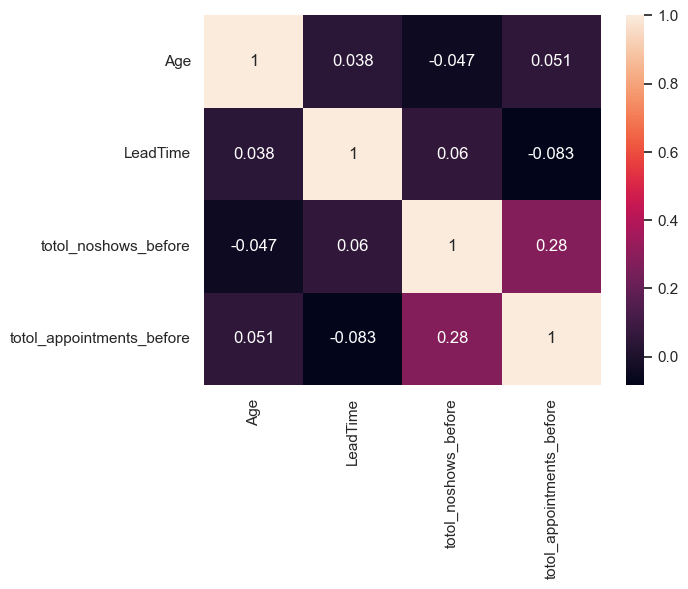

In [53]:
corr = X_train[numerical_features].corr(method='pearson')
sns.heatmap(corr, annot=True)

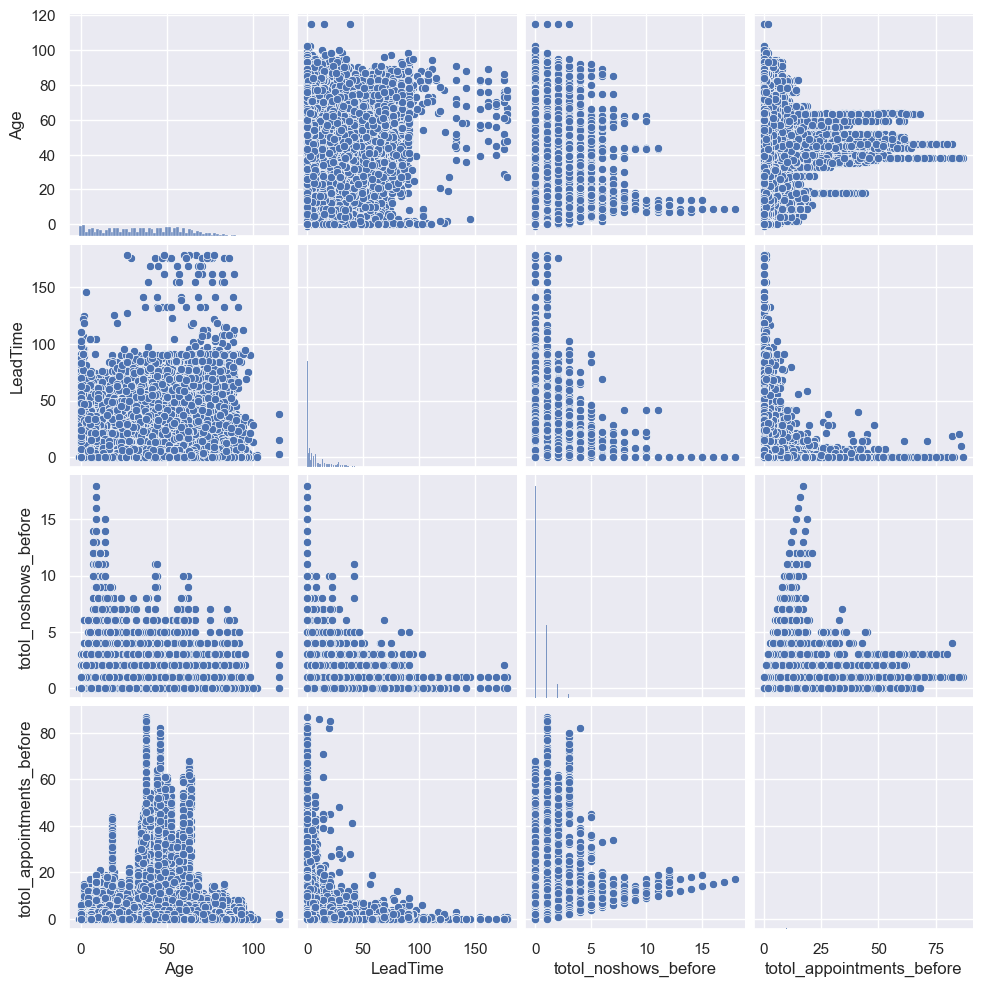

In [54]:
sns.pairplot(X_train[numerical_features])

### Insights: Numerical featrures are not strongly correlated

# 4. Modeling

## 4.1 Feature Encoding

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
ctf = ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop="if_binary"), categorical_features),
                                      ('std', StandardScaler(), numerical_features)], remainder='passthrough', verbose_feature_names_out=False)

In [56]:
X_train = pd.DataFrame(ctf.fit_transform(X_train), columns=ctf.get_feature_names_out())
X_test = pd.DataFrame(ctf.transform(X_test), columns=ctf.get_feature_names_out())

In [57]:
X_train.head()

,Gender_M,MedicaidIND_1,Hypertension_1,Diabetes_1,Alcoholism_1,Disability_0,Disability_1,Disability_2,Disability_3,Disability_4,SMS_received_1,Age,LeadTime,totol_noshows_before,totol_appointments_before
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.088539,-0.667426,-0.514632,0.453554
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.083445,-0.667426,-0.514632,-0.068320
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.819853,-0.275169,0.734571,-0.329258
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.434594,-0.667426,-0.514632,-0.068320
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.175053,1.620741,-0.514632,-0.068320


In [58]:
X_train.shape

(88417, 15)

In [59]:
y_train.head()

71721    0
91358    0
64454    1
82016    0
9564     0
Name: NoShow, dtype: int64

## 4.2 Benchmark: Logistic Regression

### Model building

In [60]:
from sklearn.linear_model import LogisticRegression
steps = [('logr', LogisticRegression(class_weight = 'balanced'))]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

In [61]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(classification_report(y_train, y_train_pred, labels=[0, 1]))
print(classification_report(y_test, y_test_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     70566
           1       0.72      0.97      0.83     17851

    accuracy                           0.92     88417
   macro avg       0.86      0.94      0.89     88417
weighted avg       0.94      0.92      0.92     88417

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     17642
           1       0.73      0.97      0.83      4463

    accuracy                           0.92     22105
   macro avg       0.86      0.94      0.89     22105
weighted avg       0.94      0.92      0.92     22105



In [62]:
from sklearn.metrics import confusion_matrix

print('Training set confusion matrix')
confusion_matrix(y_train, y_train_pred)

Training set confusion matrix


array([[63791,  6775],
       [  501, 17350]], dtype=int64)

In [63]:
print('Test set confusion matrix')
confusion_matrix(y_test, y_test_pred)

Test set confusion matrix


array([[16002,  1640],
       [  128,  4335]], dtype=int64)

In [64]:
y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(y_train, y_train_proba[:, 1])

0.9672091493893308

In [66]:
roc_auc_score(y_test, y_test_proba[:, 1])

0.9679633443535014

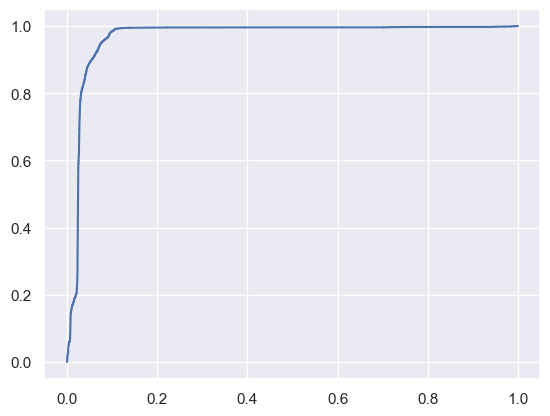

In [67]:
fpr, tpr, threshold = roc_curve(y_test, y_test_proba[:, 1])
plt.plot(fpr, tpr)

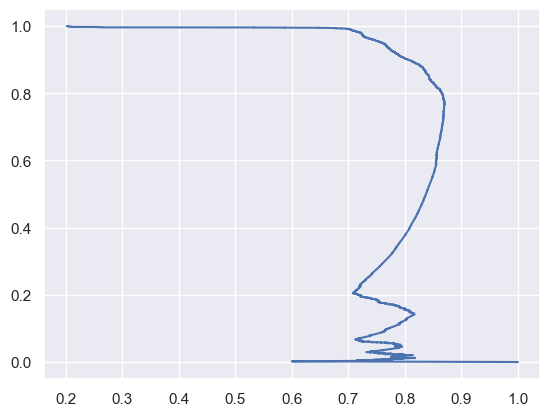

In [68]:
from sklearn.metrics import precision_recall_curve
prec, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
plt.plot(prec, recall)

#### Cross validation

In [69]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)
print("%0.4f train_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
scores = cross_val_score(model, X_test, y_test, scoring='roc_auc', cv=5)
print("%0.4f test_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

0.9672 train_roc_auc with a standard deviation of 0.0017
0.9682 test_roc_auc with a standard deviation of 0.0020


### SMOTE

In [70]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2023)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [71]:
steps = [('logr', LogisticRegression())]
model = Pipeline(steps)
model = model.fit(X_train_sm, y_train_sm)

y_train_sm_pred = model.predict(X_train_sm)
y_test_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_train_sm, y_train_sm_pred, labels=[0, 1]))
print(classification_report(y_test, y_test_pred, labels=[0, 1]))

y_train_sm_proba = model.predict_proba(X_train_sm)
y_test_proba = model.predict_proba(X_test)

print('train_sm ROC_AUC: ', roc_auc_score(y_train_sm, y_train_sm_proba[:, 1]))
print('test ROC_AUC: ', roc_auc_score(y_test, y_test_proba[:, 1]))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     70566
           1       0.91      0.97      0.94     70566

    accuracy                           0.94    141132
   macro avg       0.94      0.94      0.94    141132
weighted avg       0.94      0.94      0.94    141132

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     17642
           1       0.73      0.97      0.83      4463

    accuracy                           0.92     22105
   macro avg       0.86      0.94      0.89     22105
weighted avg       0.94      0.92      0.92     22105

train_sm ROC_AUC:  0.9680192407331472
test ROC_AUC:  0.9681292145932383


#### Cross Validation

In [72]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train_sm, y_train_sm, scoring='roc_auc', cv=5)
print("%0.4f train_sm_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
scores = cross_val_score(model, X_test, y_test, scoring='roc_auc', cv=5)
print("%0.4f test_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

0.9680 train_sm_roc_auc with a standard deviation of 0.0012
0.9631 test_roc_auc with a standard deviation of 0.0051


### Hyperparameter Tuning

In [73]:
from sklearn.model_selection import GridSearchCV

parameters = {'penalty': ['l1','l2','elasticnet'],
              'C': [0.1, 0.5, 1, 5, 10, 50, 100]}

model = LogisticRegression(class_weight = 'balanced')
lr_gsv = GridSearchCV(model, 
                      parameters, 
                      cv=3,
                      n_jobs=-1, 
                      scoring='roc_auc',
                      return_train_score=True)

lr_gsv = lr_gsv.fit(X_train, y_train)

In [74]:
print('best params: %s' % lr_gsv.best_params_)

best params: {'C': 100, 'penalty': 'l2'}


In [75]:
y_train_pred = lr_gsv.predict(X_train)
y_test_pred = lr_gsv.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred, labels=[0, 1]))
print(classification_report(y_test, y_test_pred, labels=[0, 1]))

y_train_proba = lr_gsv.predict_proba(X_train)
y_test_proba = lr_gsv.predict_proba(X_test)

print('train best ROC_AUC: ', roc_auc_score(y_train, y_train_proba[:, 1]))
print('test best ROC_AUC: ', roc_auc_score(y_test, y_test_proba[:, 1]))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     70566
           1       0.72      0.97      0.83     17851

    accuracy                           0.92     88417
   macro avg       0.86      0.94      0.89     88417
weighted avg       0.94      0.92      0.92     88417

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     17642
           1       0.73      0.97      0.83      4463

    accuracy                           0.92     22105
   macro avg       0.86      0.94      0.89     22105
weighted avg       0.94      0.92      0.92     22105

train best ROC_AUC:  0.9672093764322607
test best ROC_AUC:  0.9679673450522394


### Feature important: coefficient weights

In [76]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,16))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

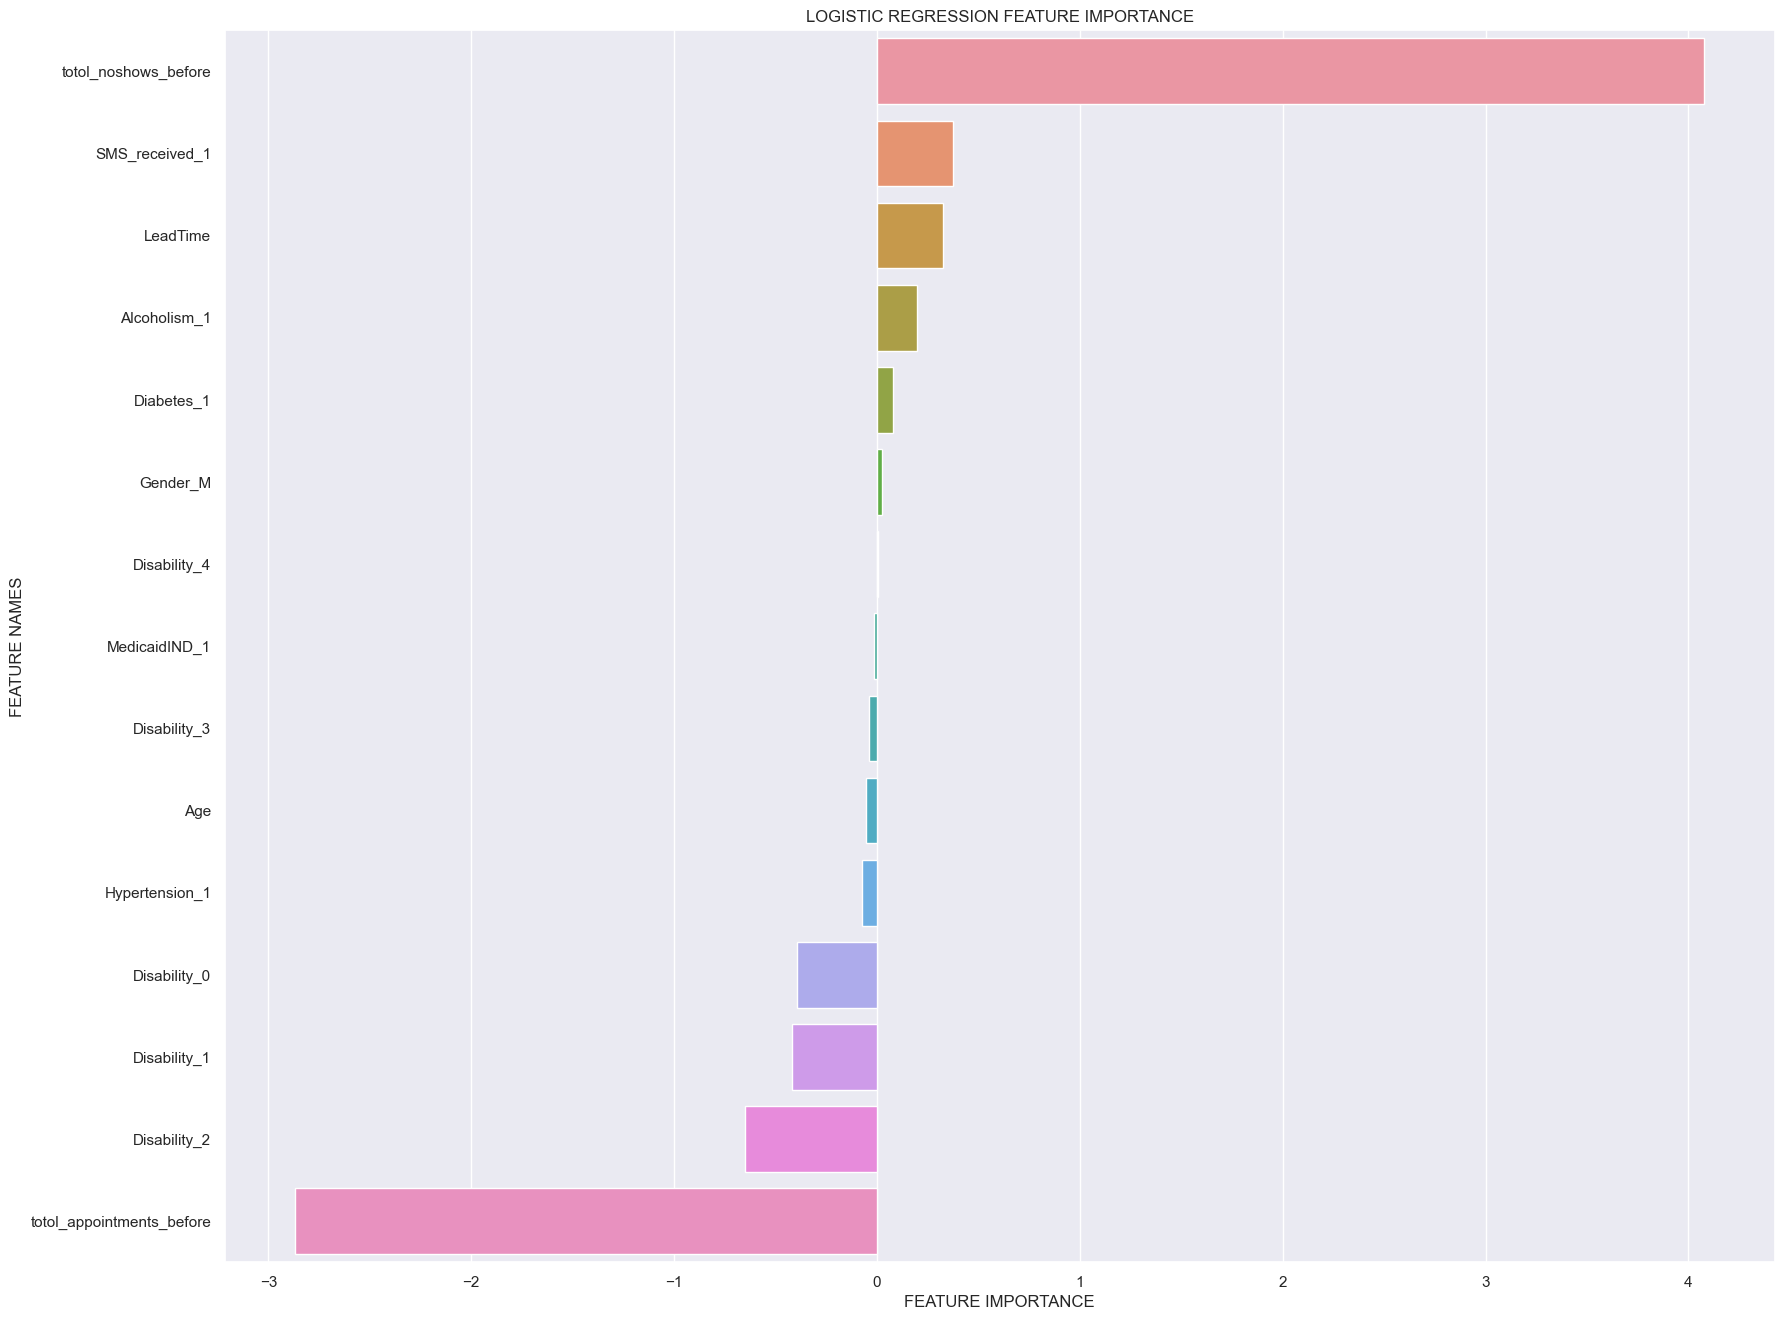

In [77]:
plot_feature_importance(lr_gsv.best_estimator_.coef_.flatten(),X_train.columns,'LOGISTIC REGRESSION')

## 4.3 Tree-based Models: Random Forest

In [78]:
from sklearn.ensemble import RandomForestClassifier
steps = [('tree', RandomForestClassifier(class_weight='balanced'))]
model = Pipeline(steps)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

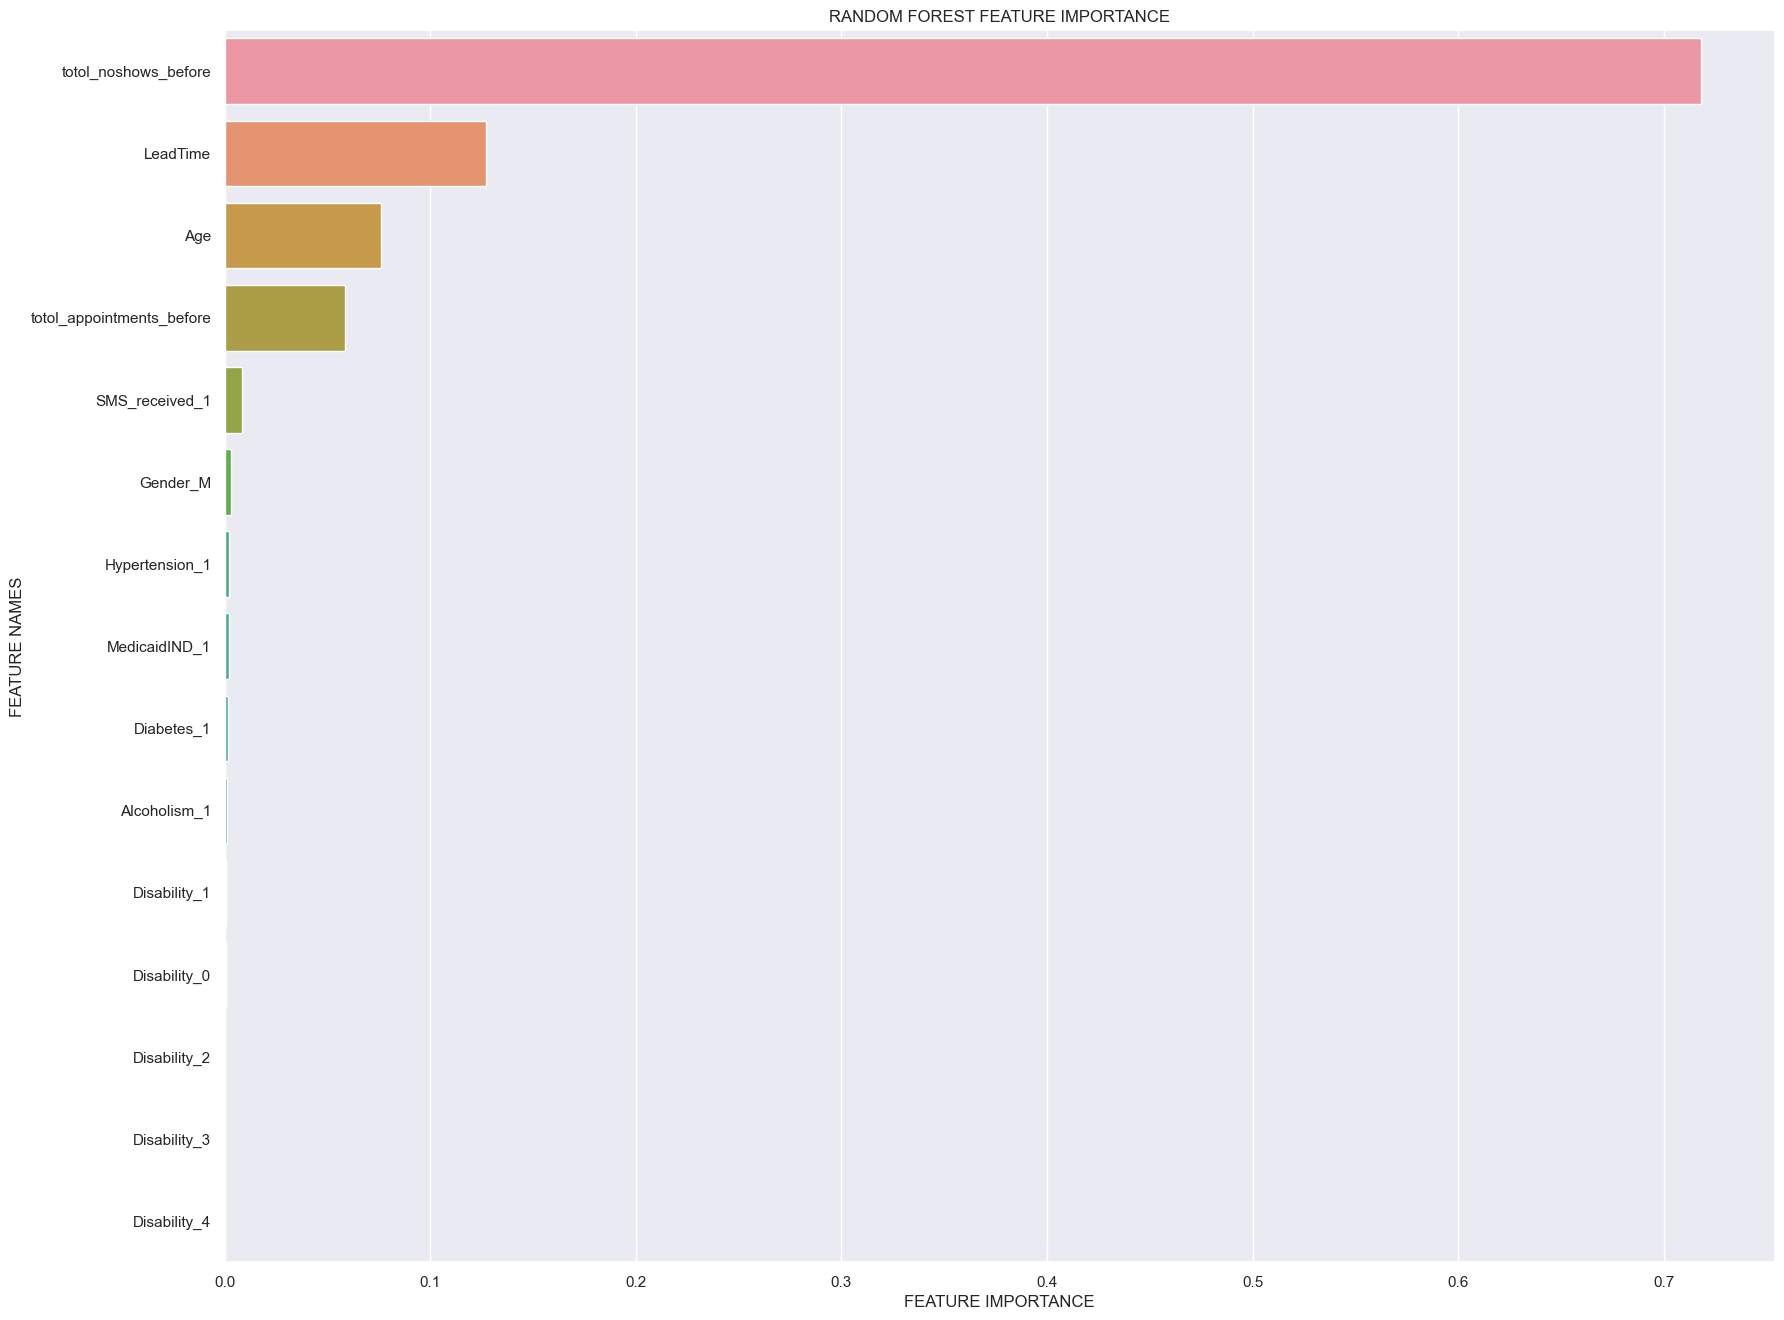

In [79]:
plot_feature_importance(model.steps[0][1].feature_importances_,X_train.columns,'RANDOM FOREST')

In [80]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred, labels=[0, 1]))
print(classification_report(y_test, y_test_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70566
           1       0.96      0.99      0.98     17851

    accuracy                           0.99     88417
   macro avg       0.98      0.99      0.99     88417
weighted avg       0.99      0.99      0.99     88417

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     17642
           1       0.84      0.86      0.85      4463

    accuracy                           0.94     22105
   macro avg       0.90      0.91      0.91     22105
weighted avg       0.94      0.94      0.94     22105



In [81]:
y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

In [82]:
roc_auc_score(y_train, y_train_proba[:, 1])

0.9994841918049591

In [83]:
roc_auc_score(y_test, y_test_proba[:, 1])

0.9835441925946025

#### Cross Validation

In [84]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)
print("%0.4f train_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
scores = cross_val_score(model, X_test, y_test, scoring='roc_auc', cv=5)
print("%0.4f test_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

0.9830 train_roc_auc with a standard deviation of 0.0013
0.9839 test_roc_auc with a standard deviation of 0.0010


### SMOTE

In [85]:
steps = [('tree', RandomForestClassifier())]
model = Pipeline(steps)
model = model.fit(X_train_sm, y_train_sm)

y_train_sm_pred = model.predict(X_train_sm)
y_test_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_train_sm, y_train_sm_pred, labels=[0, 1]))
print(classification_report(y_test, y_test_pred, labels=[0, 1]))

y_train_sm_proba = model.predict_proba(X_train_sm)
y_test_proba = model.predict_proba(X_test)

print('train_sm ROC_AUC: ', roc_auc_score(y_train_sm, y_train_sm_proba[:, 1]))
print('test ROC_AUC: ', roc_auc_score(y_test, y_test_proba[:, 1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70566
           1       0.99      0.99      0.99     70566

    accuracy                           0.99    141132
   macro avg       0.99      0.99      0.99    141132
weighted avg       0.99      0.99      0.99    141132

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     17642
           1       0.83      0.89      0.86      4463

    accuracy                           0.94     22105
   macro avg       0.90      0.92      0.91     22105
weighted avg       0.94      0.94      0.94     22105

train_sm ROC_AUC:  0.9998240706131928
test ROC_AUC:  0.9837618369562603


In [ ]:
plot_feature_importance(model.steps[0][1].feature_importances_, X_train.columns, 'RANDOM FOREST SMOTE')

#### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train_sm, y_train_sm, scoring='roc_auc', cv=5)
print("%0.4f train_sm_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
scores = cross_val_score(model, X_test, y_test, scoring='roc_auc', cv=5)
print("%0.4f test_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

### Threshold tuning

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_test_proba[:, 1])
plt.plot(fpr, tpr)

In [ ]:
# Plot metrics scores v.s. threshold
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0, 1, 10)
precisions = []
recalls = []
f1s = []
ave = "binary"

for cut in thresholds:
    y_test_predic = (y_test_proba[:, 1] > cut).astype(int)
    precisions.append(precision_score(y_test, y_test_predic, average=ave))
    recalls.append(recall_score(y_test, y_test_predic, average=ave))
    f1s.append(f1_score(y_test, y_test_predic, average=ave))

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

## 4.3 Tree-based Models: XGBoost

In [ ]:
# !pip install xgboost?

In [ ]:
import xgboost as xgb
gbt = xgb.XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1))
gbt.fit(X_train, y_train)

y_train_pred = gbt.predict(X_train)
y_test_pred = gbt.predict(X_test)

y_train_probs = gbt.predict_proba(X_train)
y_test_probs = gbt.predict_proba(X_test)

print(classification_report(y_train, y_train_pred, labels=[0, 1]))
print(classification_report(y_test, y_test_pred, labels=[0, 1]))

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

fpr, tpr, threshold = roc_curve(y_test, y_test_proba[:, 1])
plt.plot(fpr,tpr)

In [ ]:
plot_feature_importance(gbt.feature_importances_, X_train.columns, 'XGBOOST')

#### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbt, X_train, y_train, scoring='roc_auc', cv=5)
print("%0.4f train_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
scores = cross_val_score(gbt, X_test, y_test, scoring='roc_auc', cv=5)
print("%0.4f test_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

### SMOTE

In [ ]:
gbt = xgb.XGBClassifier()
gbt = gbt.fit(X_train_sm, y_train_sm)

y_train_sm_pred = model.predict(X_train_sm)
y_test_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_train_sm, y_train_sm_pred, labels=[0, 1]))
print(classification_report(y_test, y_test_pred, labels=[0, 1]))

y_train_sm_proba = model.predict_proba(X_train_sm)
y_test_proba = model.predict_proba(X_test)

print('train_sm ROC_AUC: ', roc_auc_score(y_train_sm, y_train_sm_proba[:, 1]))
print('test ROC_AUC: ', roc_auc_score(y_test, y_test_proba[:, 1]))

In [ ]:
plot_feature_importance(gbt.feature_importances_, X_train.columns, 'XGBOOST SMOTE')

#### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbt, X_train_sm, y_train_sm, scoring='roc_auc', cv=5)
print("%0.4f train_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
scores = cross_val_score(gbt, X_test, y_test, scoring='roc_auc', cv=5)
print("%0.4f test_roc_auc with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

### Threshold tuning

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_test_proba[:, 1])
plt.plot(fpr, tpr)

In [ ]:
# Plot metrics scores v.s. threshold
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0, 1, 10)
precisions = []
recalls = []
f1s = []
ave = "binary"

for cut in thresholds:
    y_test_predic = (y_test_proba[:, 1] > cut).astype(int)
    precisions.append(precision_score(y_test, y_test_predic, average=ave))
    recalls.append(recall_score(y_test, y_test_predic, average=ave))
    f1s.append(f1_score(y_test, y_test_predic, average=ave))

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

**Bonus: Pycaret**

In [ ]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(train, target = 'NoShow', session_id = 42)

In [ ]:
best = s.compare_models()

In [ ]:
s.save_model(best, 'my_best_pipeline')

In [ ]:
best = s.load_model('my_best_pipeline')

# 5. Summary

* All three models achieved high ROC-AUC > 0.95, precision and recall scores > 0.8 on the test set without overfitting.

* Tree-based ensemble models performed even better than the benchmark model of Logistic Regression as they capture nonlinearity and are more robust to outliers.

* The two new features (total_noshows_before and total_appointments_before) are the top 2 predictors in all the models, suggesting appointment history of a patient indicating future behaviors.

* Longer Lead time and lower Age are also suggesting higher probability of NoShow.

* Deploy the models as a web app using Flask and serve it on the GCP; integrate them into the work pipeline to enhance operational efficiency

* Communicate with stakeholders and senior leadership to better define the new problem and iteratively optimize the models

* Constantly maintain, monitor the model performance with new data

* Retrain, update and fix the models if seen errors or degradation 

# 6. Actionable Suggestions

* If a patient is of high probability of no-show, consider a double booking to cut loss.

* For patients with frequent no-shows (> 3 times per year), charge additional no-show fees to cut loss.

* As many patients who made appointments on the same day but did not receive SMS missed the appointments, try to reach them with phone call to reduce no-show.

* Set up more clinics in patients' neighborhood to reduce no-show.

* Launch promotion campaign (candy, gift cards, etc.) to reduce no-show.

* Run A/B testing on the suggestions and collect data, perform statistical tests to determine whether the actions are effective or not.